# Step 3: Optimization with uncertain conversion rates

In [81]:
# fixed graph weights (same click influence probabilities between the products for each user)
# homogeneous users (one class with small variability)
# fixed alphas (same number of users each day distributed equally between the initial webpages)
# uncertain conversion rates

In [82]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.TS_Learner import *
from Algorithms.UCB_Learner import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
print("Margin matrix: ")
print(margins_matrix)

E = E_commerce()
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
E.set_products(products)
E.set_lambda(0.5)

Margin matrix: 
[[ 3.998  5.998  7.998 10.998]
 [ 5.998  8.598 11.998 15.998]
 [ 7.797 10.797 13.797 16.797]
 [15.596 20.596 23.596 26.596]
 [39.995 49.995 59.995 69.995]]


Using a simple algorithm trained for a long time (1000 days, repeated 10 times), we obtain an estimation of conversion rates and expected rewards of the arms for each product. This will be considered our clairvoyant solution.

In [84]:
# Random algorithm which for each round pulls a random choice
# to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
# useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100 #mean number of users for each day
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_experiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given choosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_experiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Rewards per arm of this simple algorithm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate")
print(margins_matrix*np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_experiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.97587662 0.74469768 0.25702704 0.00956913]
 [0.97072909 0.76306675 0.1590597  0.00347371]
 [0.9917092  0.82076044 0.21464399 0.00806266]
 [0.99329416 0.72037379 0.25835144 0.03513267]
 [0.99600567 0.91118628 0.1110098  0.00393293]]
_______________________________________________
Rewards per arm of this simple algorithm
[[ 7.82527936  8.95209634  4.08374027  0.14689023]
 [ 5.84362618  6.54323658  1.87304156  0.00767936]
 [23.29110237 26.63695789  8.71413691  0.20391529]
 [46.56040815 44.76508043 18.56126917  2.50576847]
 [39.995      45.72727787  6.47846545  0.        ]]
Expected rewards per arm = margin * conversion rate
[[ 3.90155473  4.46669671  2.05570223  0.10524131]
 [ 5.82243306  6.56084791  1.90839825  0.05557248]
 [ 7.73235665  8.86175046  2.96144316  0.13542857]
 [15.49141567 14.83681852  6.09606066  0.93438836]
 [39.83524665 45.55475803  6.66003296  0.27528578]]
______________________________________________

In [85]:
opt

134.2028280168975

## Thompson Sampling: optimization of the cumulative expected margin over all the products

In [86]:
print("Margin matrix: ")
print(margins_matrix)
print("Estimated conversion rates: ")
print(np.mean(conv_rates_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate ")
print(np.mean(conv_rates_per_experiment,axis=0)*margins_matrix)

Margin matrix: 
[[ 3.998  5.998  7.998 10.998]
 [ 5.998  8.598 11.998 15.998]
 [ 7.797 10.797 13.797 16.797]
 [15.596 20.596 23.596 26.596]
 [39.995 49.995 59.995 69.995]]
Estimated conversion rates: 
[[0.97587662 0.74469768 0.25702704 0.00956913]
 [0.97072909 0.76306675 0.1590597  0.00347371]
 [0.9917092  0.82076044 0.21464399 0.00806266]
 [0.99329416 0.72037379 0.25835144 0.03513267]
 [0.99600567 0.91118628 0.1110098  0.00393293]]
Expected rewards per arm = margin * conversion rate 
[[ 3.90155473  4.46669671  2.05570223  0.10524131]
 [ 5.82243306  6.56084791  1.90839825  0.05557248]
 [ 7.73235665  8.86175046  2.96144316  0.13542857]
 [15.49141567 14.83681852  6.09606066  0.93438836]
 [39.83524665 45.55475803  6.66003296  0.27528578]]


In [87]:
# Thompson Sampling
# Comparison between TS and UCB

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 20

ts_rewards_per_experiment = []
ts_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
        ts_rewards_per_day[d] += np.sum(reward)
    

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)


ts_rewards_per_day = ts_rewards_per_day/n_experiments


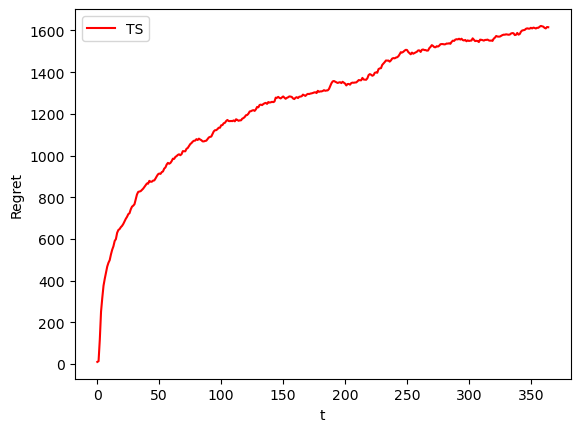

In [117]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

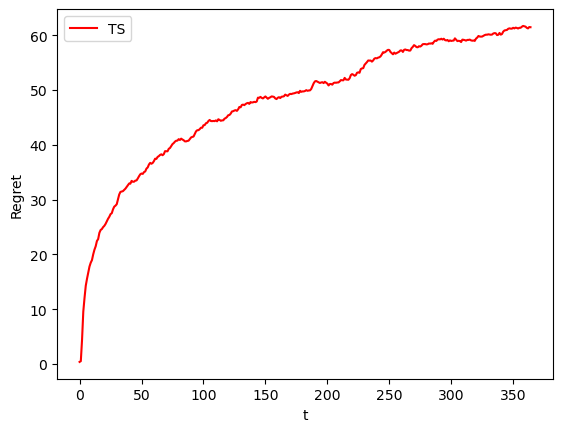

In [118]:
#Standardized
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0))/np.std(opt - ts_rewards_per_experiment), 'r')
plt.legend(["TS"])
plt.show()

In [89]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 365 days and its standard deviation considering 20 experiments
47368.350280000006 554.9792241453773
-----------------------------------------------
Total expected regret over 365 days and its standard deviation considering 20 experiments
1615.6819461675889 554.9792241453762
-----------------------------------------------
Average expected reward per round over 365 days and its standard deviation between the rounds considering 20 experiments
129.77630213698632 11.64782705557542
-----------------------------------------------
Average expected regret per round over 365 days and its standard deviation between the rounds considering 20 experiments
4.4265258799112015 11.647827055575421


Text(0.5, 1.0, 'Expected regret per round')

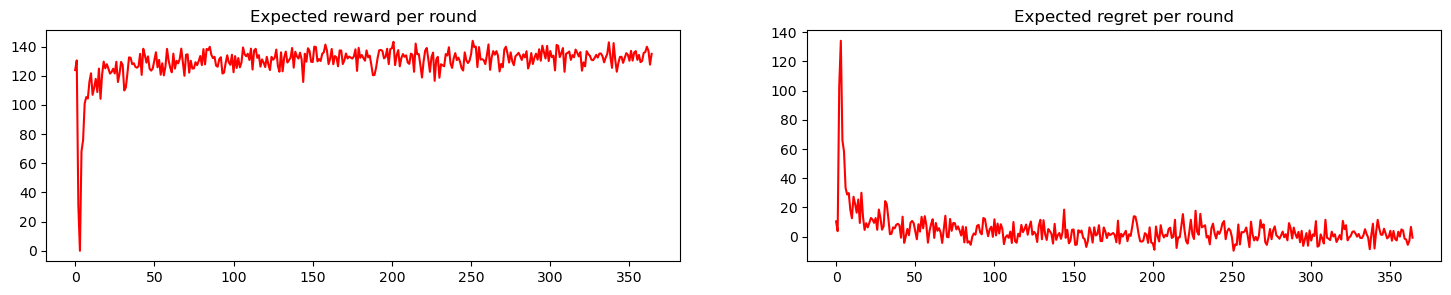

In [90]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ts_rewards_per_experiment, axis=0)), 'r')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ts_rewards_per_experiment, axis=0)), 'r')
ax[1].set_title("Expected regret per round")

In [91]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ts_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ts_learner.rewards_per_arm[i][0])-1,len(ts_learner.rewards_per_arm[i][1])-1,len(ts_learner.rewards_per_arm[i][2])-1,len(ts_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

_______________________________________________
Expected rewards per arm for the last experiment
[[ 7.996       8.90150945  4.63042105  0.        ]
 [ 5.998       6.36022063  0.          0.        ]
 [23.391      27.64839252 11.826       0.        ]
 [46.59933871 43.56846154 15.73066667 11.39828571]
 [39.995      46.3021875   8.57071429  0.        ]]
_______________________________________________
Pulls per arm for the last experiment
[3, 334, 18, 6]
[1, 348, 6, 6]
[29, 320, 6, 6]
[247, 103, 5, 6]
[1, 351, 6, 3]


In [92]:
from scipy.special import rel_entr
KL = sum(rel_entr([opt for i in range(n_days)],ts_rewards_per_day))
#KL divergence

In [93]:
KL = np.zeros(n_days)
for i in range(n_days):
    KL[i] = opt * np.log(opt/ts_rewards_per_day[i]) 

C:\Users\foxfo\AppData\Local\Temp\ipykernel_20476\1199476239.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  KL[i] = opt * np.log(opt/ts_rewards_per_day[i])


In [94]:
empiric_regret_ts = np.sum(opt-ts_rewards_per_day)
empiric_regret_ts

1615.681946167589

In [95]:
#Theoretical bounds for TS
delta_ts = opt - ts_rewards_per_day
UPPER_bound_regret_ts = (1+10)*np.log(ts_learner.t)+np.log(np.log(ts_learner.t))*np.sum(delta_ts/KL)
print("_______________________________________________")
print("Upper bound for the TS regret")
print(UPPER_bound_regret_ts)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print( empiric_regret_ts/UPPER_bound_regret_ts)


_______________________________________________
Upper bound for the TS regret
700.7549269159446
_______________________________________________
Ratio between empirical regret and upper bound for the regret
2.305630519471738


## UCB: : optimization of the cumulative expected margin over all the products

In [96]:
#UCB
n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 20

ucb_rewards_per_experiment = []

ucb_rewards_per_day_per_experiment = []
ucb_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        ucb_rewards_per_day[d] += np.sum(reward)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

ucb_rewards_per_day = ucb_rewards_per_day/n_experiments

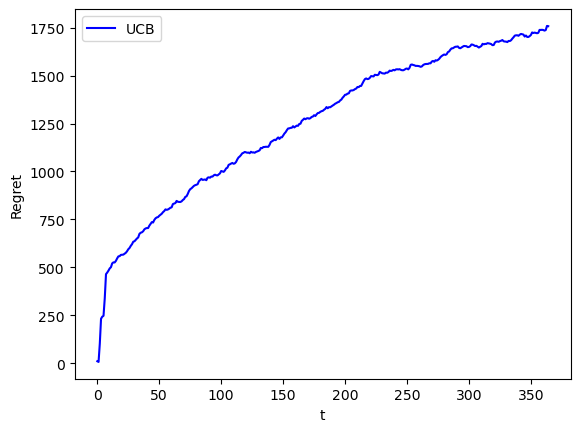

In [97]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["UCB"])
plt.show()

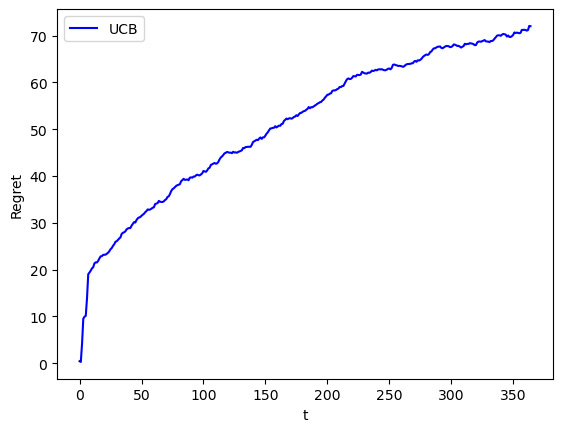

In [121]:
#Standardized
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)/np.std(opt - ucb_rewards_per_experiment)), 'b')
plt.legend(["UCB"])
plt.show()

In [120]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 365 days and its standard deviation between 20 experiments
47225.93142000001 401.2610716997115
-----------------------------------------------
Total expected regret over 365 days and its standard deviation between 20 experiments
1758.1008061675893 401.2610716997117
-----------------------------------------------
Average expected reward per round over 365 days and its standard deviation between the rounds considering 20 experiments
129.38611347945206 12.415303819960528
-----------------------------------------------
Average expected regret per round over 365 days and its standard deviation between the rounds considering 20 experiments
4.81671453744545 12.415303819960526


Text(0.5, 1.0, 'Expected regret per round')

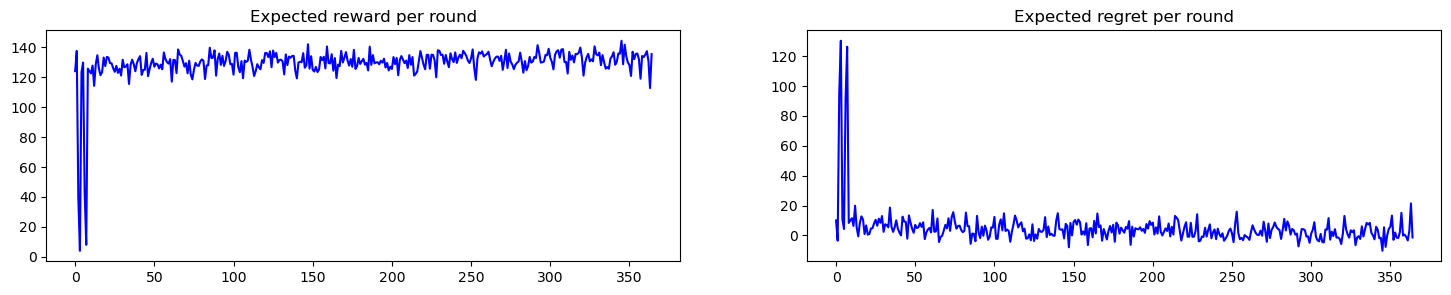

In [99]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ucb_rewards_per_experiment, axis=0)), 'b')
ax[1].set_title("Expected regret per round")

In [100]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ucb_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ucb_learner.rewards_per_arm[i][0])-1,len(ucb_learner.rewards_per_arm[i][1])-1,len(ucb_learner.rewards_per_arm[i][2])-1,len(ucb_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

print("_______________________________________________")
print("Upper confidence bounds for the last experiment")
print(ucb_learner.confidence)

_______________________________________________
Expected rewards per arm for the last experiment
[[ 7.996       9.34204624  0.          0.        ]
 [ 5.93045495  6.69738947  0.          0.        ]
 [23.32584401  0.          0.          0.        ]
 [46.40052174 40.30931429 17.697      26.596     ]
 [39.995      45.52809278 17.14142857  0.        ]]
_______________________________________________
Pulls per arm for the last experiment
[50, 309, 1, 1]
[73, 284, 1, 3]
[358, 1, 1, 1]
[321, 34, 1, 5]
[64, 290, 6, 1]
_______________________________________________
Upper confidence bounds for the last experiment
[[0.48261976 0.19541504 1.9727697  2.03933398]
 [0.40176474 0.20383467 1.9727697  1.84823591]
 [0.18154977 1.89301847 1.9727697  2.03933398]
 [0.19172763 0.57751399 1.9727697  1.34649166]
 [0.41785347 0.20171501 1.29150381 2.03933398]]


In [101]:
#Theoretical comparison (?)

opt_per_product = np.zeros(5)
delta_arms_per_product = np.zeros((5,4)) #differencees with the mean reward of the optimal arm
upper_bound_regret_per_product = np.zeros(5)
for i in range(5):
    opt_per_product[i] = np.max(margins_matrix[i,:] * conversion_rates[i])
    for j in range(4):
        delta_arms_per_product[i,j] = opt_per_product[i] - ucb_learner.expected_rewards[i,j]
        if delta_arms_per_product[i,j]>0:
            upper_bound_regret_per_product[i] += 4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j]
   

#R(UCB)<SUM(4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j])
print("Upper bound theoretical regret per product")
print(upper_bound_regret_per_product)
print("Ratio between empiric regret and the upper bound")
empiric_regret = np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1))
print(empiric_regret/np.sum(upper_bound_regret_per_product))

Upper bound theoretical regret per product
[ 85.75672853 156.25716978 213.58526483   0.         622.08398896]
Ratio between empiric regret and the upper bound
1.6313707815998468


In [102]:
#Theoretical bounds for UCB
delta_ucb = opt - ucb_rewards_per_day
UPPER_bound_regret_ucb = 4*np.log(ucb_learner.t)*np.sum(1/delta_ucb+8*delta_ucb)
empiric_regret_ucb = np.sum(opt-ucb_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the UCB regret")
print(UPPER_bound_regret_ucb)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print( empiric_regret_ucb/UPPER_bound_regret_ucb)

_______________________________________________
Upper bound for the UCB regret
332808.4483831572
_______________________________________________
Ratio between empirical regret and upper bound for the regret
0.005282620722847491


Greedy Learner: each round chose the current best solution

In [103]:
# (INUTILE)
#Greedy Learner
n_arms = 4

num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
margins_matrix = np.array([[2.,  5.,  8., 11.], [4.,  7., 10., 13.],[6.,  9., 12., 15.],[ 8., 11., 14., 17],[10., 13., 16., 19.]])

env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units=1)
gr_learner = Greedy(n_arms=n_arms)

for d in range(n_days):
    
    pulled_arm = gr_learner.pull_arm(env.margins_matrix)
    reward = env.round(pulled_arm)
    gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)

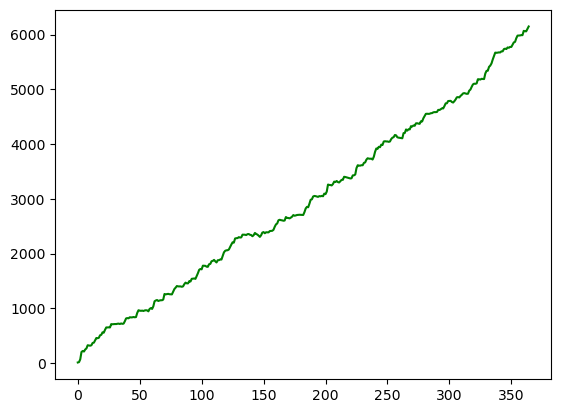

In [104]:
plt.plot(np.cumsum(opt-gr_learner.collected_rewards),'g')